 # PtyRAD - PTYchographic Reconstruction with Automatic Differentiation

 Chia-Hao Lee

cl2696@cornell.edu

Created 2024.03.08

In [7]:
from preprocess import preprocess_CBED, preprocess_ptycho_output_dict 
from optimization import cbed_rmse
from forward_model import multislice_forward_model_batch_all
from utils import cplx_from_np, complex_object_interp3d, near_field_evolution
from data_io import load_fields_from_mat, load_hdf5
from scipy.ndimage import gaussian_filter

#from visualization import plot_recon_progress


import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision.transforms import v2


GPUID = 0
DEVICE = torch.device("cuda:" + str(GPUID))
print("Execution device: ", DEVICE)
print("PyTorch version: ", torch.__version__)
print("CUDA available: ", torch.cuda.is_available())
print("CUDA version: ", torch.version.cuda)
print("CUDA device:", torch.cuda.get_device_name(GPUID))

Execution device:  cuda:0
PyTorch version:  2.1.0
CUDA available:  True
CUDA version:  12.1
CUDA device: Quadro P5000


In [8]:
# Setup data path
#ptycho_output_mat_path = "data/data3D_300kV_df_20nm_alpha_21.4mrad_Cs_0.0um_dp_128_blur_0px_dose_1.0e+08ePerAng2/1/roi_1_Ndp_128/MLs_L1_p4_g32_Ns21_dz10_reg1_dec0.92_dpFlip_T/Niter500.mat"
#exp_CBED_path = "data/data3D_300kV_df_20nm_alpha_21.4mrad_Cs_0.0um_dp_128_blur_0px_dose_1.0e+08ePerAng2/1/data_roi_1_Ndp_128_dp.hdf5"

# Exp PSO
# ptycho_output_mat_path = "data/MLs_L1_p8_g192_Ndp128_pc50_noModel_vp1_Ns21_dz10_reg1/Niter200.mat"
# exp_CBED_path = "data/MLs_L1_p8_g192_Ndp128_pc50_noModel_vp1_Ns21_dz10_reg1/PSO_data_roi0_Ndp256_dp.hdf5"

# Exp PSO
# ptycho_output_mat_path = "data/MLs_L1_p4_g32_Ns21_dz10_dpFlip_T/Niter50_ML.mat"
# exp_CBED_path = "data/MLs_L1_p4_g32_Ns21_dz10_dpFlip_T/data_roi_1_Ndp_128_dp.hdf5"

ptycho_output_mat_path = "data/Fig_1h_24.9mrad_Themis/1/roi1_Ndp128_step128\MLs_L1_p10_g128_pc0_noModel_updW100_mm_dpFlip_ud_T/Niter9000_v7.mat"
exp_CBED_path =          "data/Fig_1h_24.9mrad_Themis/1/data_roi1_Ndp128_step128_dp.hdf5"

print("Loading ptycho output and input CBED")
ptycho_output_dict = load_fields_from_mat(ptycho_output_mat_path, 'All', squeeze_me=True, simplify_cells=True)
#exp_CBED = load_empad_as_4D(exp_CBED_path, 128,130,128,128,'C')
input_CBED, CBED_source = load_hdf5(exp_CBED_path, dataset_key='dp') 
# Note that loading Matlab-generated F-order HDF5 (kx, ky, Nscan) into Python would automatically make it C-order (Nscan, ky, kx)

Loading ptycho output and input CBED
Success! .mat File path = data/Fig_1h_24.9mrad_Themis/1/roi1_Ndp128_step128\MLs_L1_p10_g128_pc0_noModel_updW100_mm_dpFlip_ud_T/Niter9000_v7.mat
Success! hdf5 File path = data/Fig_1h_24.9mrad_Themis/1/data_roi1_Ndp128_step128_dp.hdf5
Imported hdf5 data shape = (16384, 128, 128)


In [9]:
# Preprocessing and setting up the data dimension

print("Preprocessing ptycho output and experimental CBED\n")
probe, object, exp_params = preprocess_ptycho_output_dict(ptycho_output_dict)
cbeds                     = np.flip(input_CBED, axis=1) # preprocess_CBED(exp_CBED) # (Nscan, ky, kx) that matches the .tif view
cbeds[cbeds<0] = 0

# Prepare the experimental param for forward model and dataset generation
lambd           = exp_params['lambd']
dx_spec         = exp_params['dx_spec']
z_distance      = 10.803 #exp_params['z_distance_arr'][0] # Ang, for 2D input, put the final desired total thickness if you're planning to do multislice
probe_positions = exp_params['probe_positions']
Nlayer          = exp_params['Nlayer']
N_scans         = exp_params['N_scans']

# Preprocessing variables for tBL-WSe2 with Themis
object = object[None, :,:]#object.transpose((2,0,1)) # Converting object into (Nz, Ny, Nx)
probe = probe.transpose((2,0,1))        # Converting probe into (pmode, Ny, Nx)
      
print(f"\nobject dtype/shape          (Nz, Ny, Nx) = {object.dtype}, {object.shape},\
        \nprobe data dtype/shape   (pmode, Ny, Nx) = {probe.dtype}, {probe.shape},\
        \ncbeds data dtype/shape       (N, Ky, Kx) = {cbeds.dtype}, {cbeds.shape}")

Preprocessing ptycho output and experimental CBED

Handling single slice ptycho .mat
`z_distance_arr` and `Nlayer` is populted with 1 and 1

object dtype/shape          (Nz, Ny, Nx) = complex128, (1, 592, 592),        
probe data dtype/shape   (pmode, Ny, Nx) = complex128, (10, 128, 128),        
cbeds data dtype/shape       (N, Ky, Kx) = float64, (16384, 128, 128)


In [10]:

# Reslice the z slices
final_z = 13 # z slices #21 for PSO
z_zoom = final_z / Nlayer
z_distance = z_distance / z_zoom # Scale the interlayer distance based on z_zoom
z_extent = final_z * z_distance
object = complex_object_interp3d(object, (z_zoom, 1, 1), z_axis = 0, use_np_or_cp = 'np') # Use cp for faster interpolation and convert it back to np with .get() as a default postprocessing
print(f"z_zoom = {z_zoom}, final_z = {final_z} slices, z_distance = {z_distance:.4f} Ang, z_extent = {z_extent:4f} Ang")

# Calculate the crop coordinates with floating points
probe_positions = probe_positions[:, [1,0]] # The first index after shifting is the row index (along vertical axis)
crop_coordinates = probe_positions + np.ceil((object.shape[-1]/2) - (probe.shape[-1]/2)) - 1 # For Matlab - Python index shift
sub_px_shift = crop_coordinates - np.round(crop_coordinates) # This shift (tH, tW) would be added to the probe to compensate the integer obj cropping
crop_indices = np.round(crop_coordinates) # This one is rounded and 

## Calculate propagator for multislice forward model
extent = dx_spec * np.array(probe.shape[-2:])
_, H, _, _ = near_field_evolution(probe.shape[-2:], z_distance, lambd, extent, use_ASM_only=True, use_np_or_cp='np')

# Specify forward model accuracy options
N_max = 16384
pmode_max = 10 # 4
omode_max = 1 # By default we only do 1 object mode

obj_power_factor = np.exp(np.log(0.02)/2/final_z) # Multiply the object by this factor would result a 2% total scattering intensity in the CBED after all the loss from all multiplicative slices
object_data = np.stack([object if i < 1 else gaussian_filter(object, sigma = (0,i//2, i%2)) * obj_power_factor for i in range(omode_max)], axis=0).astype('complex64') # Adding gaussian blur to the obj modes
probe_data = probe[:pmode_max, :, :].astype('complex64')
crop_indices_data = crop_indices[:N_max].astype('int32')
shift_vec_data = sub_px_shift.astype('float32')
cbeds_data = cbeds[:N_max].astype('float32')
H = H.astype('complex64')
      
print(f"\nobject_data dtype/shape (omode, Nz, Ny, Nx) = {object_data.dtype}, {object_data.shape}, \
        \nprobe_data dtype/shape      (pmode, Ny, Nx) = {probe_data.dtype}, {probe_data.shape}, \
        \ncrop_indices_data                     (N,2) = {crop_indices_data.dtype}, {crop_indices_data.shape}, \
        \nshift_vec_data                        (N,2) = {shift_vec_data.dtype}, {shift_vec_data.shape}, \
        \ncbeds_data dtype/shape          (N, Ky, Kx) = {cbeds_data.dtype}, {cbeds_data.shape}, \
        \nH dtype/shape                      (Ky, Kx) = {H.dtype}, {H.shape}")

The object shape is interpolated to (13, 592, 592).
z_zoom = 13.0, final_z = 13 slices, z_distance = 0.8310 Ang, z_extent = 10.803000 Ang

object_data dtype/shape (omode, Nz, Ny, Nx) = complex64, (1, 13, 592, 592),         
probe_data dtype/shape      (pmode, Ny, Nx) = complex64, (10, 128, 128),         
crop_indices_data                     (N,2) = int32, (16384, 2),         
shift_vec_data                        (N,2) = float32, (16384, 2),         
cbeds_data dtype/shape          (N, Ky, Kx) = float32, (16384, 128, 128),         
H dtype/shape                      (Ky, Kx) = complex64, (128, 128)


In [11]:
z_distance

0.8310000000000001

In [12]:
crop_coordinates

array([[ 47.52546692,  48.49961853],
       [ 48.13729858,  50.95301819],
       [ 48.42604065,  53.32331848],
       ...,
       [411.19865417, 405.86024475],
       [411.08374023, 408.47093201],
       [410.86943054, 411.57783508]])

In [13]:
sub_px_shift

array([[-0.47453308,  0.49961853],
       [ 0.13729858, -0.04698181],
       [ 0.42604065,  0.32331848],
       ...,
       [ 0.19865417, -0.13975525],
       [ 0.08374023,  0.47093201],
       [-0.13056946, -0.42216492]])

In [14]:
crop_indices_data



array([[ 48,  48],
       [ 48,  51],
       [ 48,  53],
       ...,
       [411, 406],
       [411, 408],
       [411, 412]])

### Note: Everything is still np array (complex) from this cell, it'll be converted to tensor later

## Build the model object

In [15]:
# Currently putting the model in the notbeook, but eventually would move to another module

class PtychoAD(torch.nn.Module):
    def __init__(self, init_obj, init_probe, init_crop_pos, init_probe_pos_shifts, H, lr_params=None, device='cuda:0'):
        super(PtychoAD, self).__init__()
        with torch.no_grad():
            self.device = device
            self.opt_obj = cplx_from_np(init_obj, cplx_type="amp_phase", ndim=-1).to(self.device)
            self.opt_probe = cplx_from_np(init_probe, cplx_type="amp_phase", ndim=-1).to(self.device) 
            self.opt_probe_pos_shifts = torch.tensor(init_probe_pos_shifts, device=self.device)
            self.crop_pos = torch.tensor(init_crop_pos, dtype=torch.int32, device=self.device)
            self.H = torch.tensor(H, dtype=torch.complex64, device=self.device)
            self.roi_shape = init_probe.shape[-2:]
            self.shift_probes = (lr_params['probe_pos_shifts'] != 0) # Set shift_probes to False if lr_params['probe_pos_shifts'] = 0
            
            # Create a dictionary to store the optimizable tensors
            self.optimizable_tensors = {
                'obj': self.opt_obj,
                'probe': self.opt_probe,
                'probe_pos_shifts': self.opt_probe_pos_shifts
            }

            self.optimizer_params = []
            if lr_params:
                for param_name, lr in lr_params.items():
                    if param_name in self.optimizable_tensors:
                        self.optimizable_tensors[param_name].requires_grad = (lr != 0)  # Set requires_grad based on learning rate
                        if lr != 0:
                            self.optimizer_params.append({'params': [self.optimizable_tensors[param_name]], 'lr': lr})
                    else:
                        print(f"Warning: '{param_name}' is not a valid parameter name.")

            print('PtychoAD major variables:')
            for name, tensor in self.optimizable_tensors.items():
                print(f"{name}: {tensor.shape}, {tensor.dtype}, device:{tensor.device}, grad:{tensor.requires_grad}, lr:{lr_params[name]:.0e}")
            
    def get_obj_ROI(self, indices):
        """ Get object ROI with integer coordinates """
        # It's strongly recommended to do integer version of get_obj_ROI
        # opt_obj.shape = (B,D,H,W,C) = (omode,D,H,W,2)
        # object_patches = (N,B,D,H,W,2), N is the additional sample index within the input batch, B is now used for omode.
        
        height, width  = self.roi_shape[0], self.roi_shape[1]
        object_patches = torch.zeros((len(indices), *self.opt_obj.shape[:2], height, width, 2)).to(self.device)

        for i, idx in enumerate(indices):
            height_start, height_end = self.crop_pos[idx,0], self.crop_pos[idx,0] + height
            width_start,  width_end  = self.crop_pos[idx,1], self.crop_pos[idx,1] + width
            object_patch      =  self.opt_obj[:, :, height_start:height_end, width_start:width_end, :] # object_patch (omode, D,H,W,2), 2 for the amp/phase channel
            object_patches[i] = object_patch

        return object_patches

    def get_probes(self, indices):
        """ Get probes for each position """
        # If you're not trying to optimize probe positions, there's not much point using sub-px shifted stationary probes
        # This function will return a single probe when self.shift_probes = False,
        # and would only be returning multiple sub-px shifted probes if you're optimizing self.opt_probe_pos_shifts

        if self.shift_probes:
            temp_probe = self.opt_probe.permute(0,3,1,2) # (pmode, Ny, Nx, 2) -> (pmode, 2, Ny, Nx)
            probes = torch.zeros((len(indices), *temp_probe.shape)).to(self.device) # (N, pmode, 2, Ny, Nx)

            for i, idx in enumerate(indices):
                tH = self.opt_probe_pos_shifts[idx][0] # Note that translate (a,b) is in unit of px, although the doc says it's fractional
                tW = self.opt_probe_pos_shifts[idx][1] # positive is moving to right/down for tW and tH.
                probes[i] = v2.functional.affine(temp_probe, translate = (tW, tH), interpolation=v2.InterpolationMode.BILINEAR, angle=0, scale=1, shear=0) 
            probes = probes.permute(0,1,3,4,2) # (N, pmode, Ny, Nx, 2)
        else:
            probes = self.opt_probe[None,...] # Extend a singleton N dimension, essentially using same probe for all samples
        
        return probes
        
    def forward(self, indices):
        """ Doing the forward pass and get an output diffraction pattern for each input index """
        # The indices are passed as an array and representing the whole batch
        
        object_patches = self.get_obj_ROI(indices)
        probes = self.get_probes(indices)
        dp_fwd = multislice_forward_model_batch_all(object_patches, probes, self.H)
        
        return dp_fwd

## Create optimization object

In [115]:
z_distance = 16/10 # Ang 10.803
_, H, _, _ = near_field_evolution(probe.shape[-2:], z_distance, lambd, extent, use_ASM_only=True, use_np_or_cp='np')
init_obj      = np.exp(1j * 0.05*np.random.rand(1,10,592,592)).astype('complex64') # init_obj = object_data
#init_obj      = np.exp(1j * 0.05*np.random.rand(*object_data.shape)).astype('complex64') # init_obj = object_data
#init_obj              = object_data
init_probe            = probe_data
init_crop_pos         = crop_indices_data
init_probe_pos_shifts = shift_vec_data
measurements  = torch.from_numpy(cbeds_data).cuda()

model = PtychoAD(init_obj, init_probe, init_crop_pos, init_probe_pos_shifts, H, 
                lr_params={'obj': 1e-3, 
                           'probe': 0, 
                           'probe_pos_shifts': 0},
                device=DEVICE)

opt = torch.optim.Adam(model.optimizer_params)

PtychoAD major variables:
obj: torch.Size([1, 10, 592, 592, 2]), torch.float32, device:cuda:0, grad:True, lr:1e-03
probe: torch.Size([10, 128, 128, 2]), torch.float32, device:cuda:0, grad:False, lr:0e+00
probe_pos_shifts: torch.Size([16384, 2]), torch.float32, device:cuda:0, grad:False, lr:0e+00


## Check the forward pass

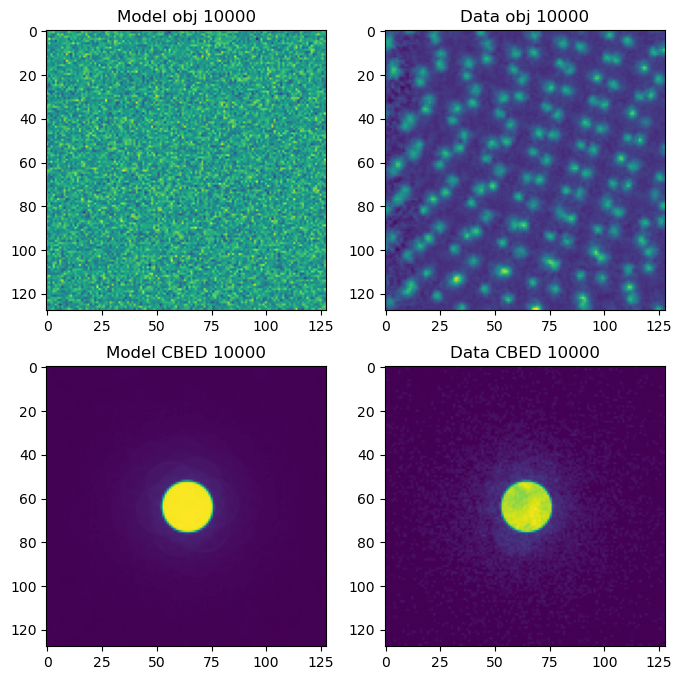

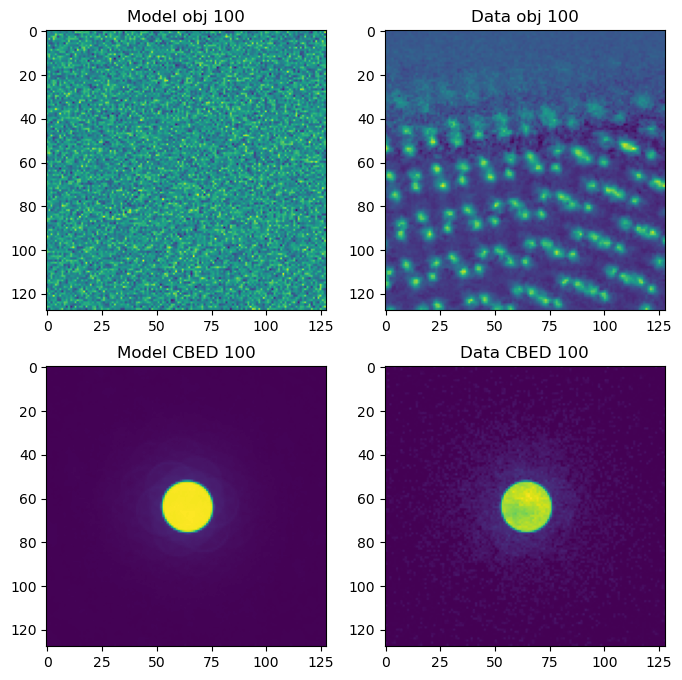

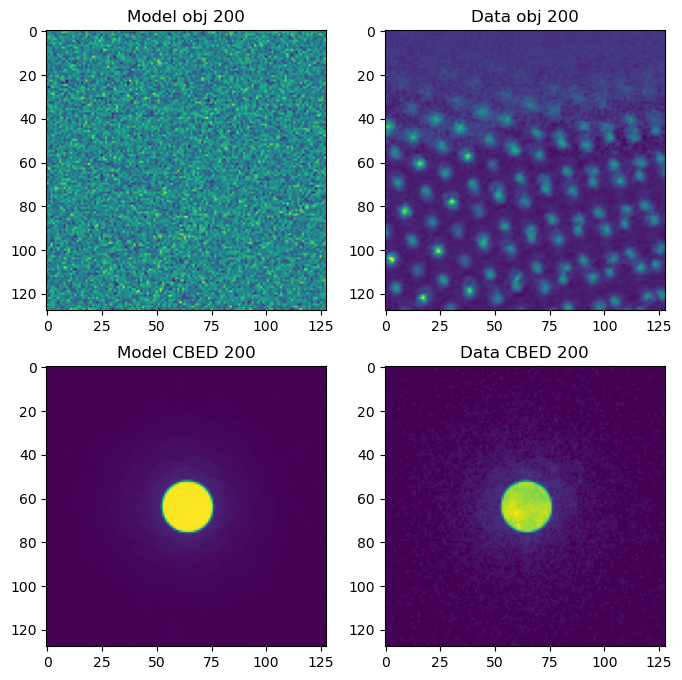

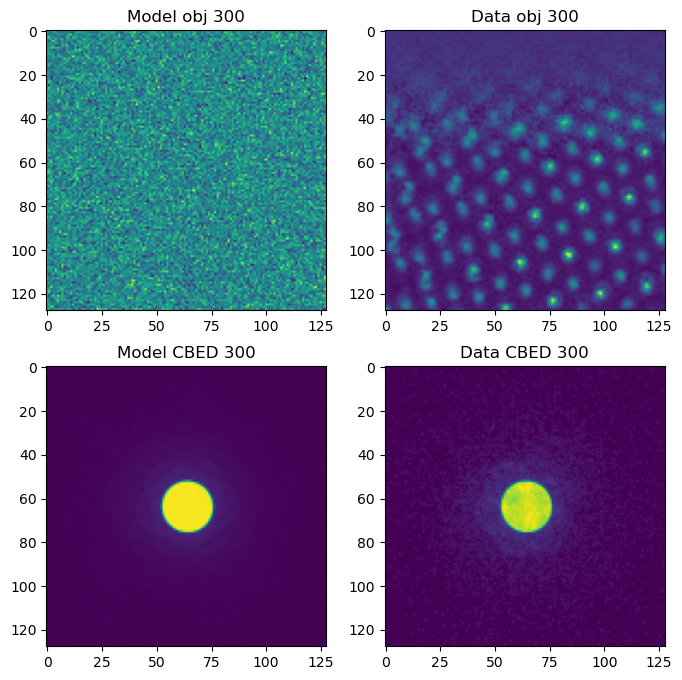

In [116]:
indices = [10000,100,200,300]
dp_power = 0.5

dp_fwd = model(indices).detach().cpu()
obj_ROI = model.get_obj_ROI(indices).detach().cpu()

for i, idx in enumerate(indices):

    fig, axs = plt.subplots(2, 2, figsize=(8, 8))

    object_patch = np.angle(object_data[0,0,crop_indices_data[idx,0]:crop_indices_data[idx,0]+probe.shape[-1],crop_indices_data[idx,1]:crop_indices_data[idx,1]+probe.shape[-1]])
    
    axs[0, 0].imshow(obj_ROI[i,0,:,:,:,1].sum(0))
    axs[0, 0].set_title(f"Model obj {idx}")

    axs[0, 1].imshow(object_patch)
    axs[0, 1].set_title(f"Data obj {idx}")

    axs[1, 0].imshow(dp_fwd[i]**dp_power)
    axs[1, 0].set_title(f"Model CBED {idx}")

    axs[1, 1].imshow(cbeds_data[idx]**dp_power)
    axs[1, 1].set_title(f"Data CBED {idx}")

    plt.show()



## Main optimization loop

In [117]:
from time import time
from IPython.display import clear_output
from torchmetrics.image import TotalVariation
# https://lightning.ai/docs/torchmetrics/stable/image/total_variation.html 
# This TV only applies to the last 2 dim (N,C,H,W)

NITER = 10
BATCH_SIZE = 32 # The actual batch size would only be "close" if it's not divisible by len(measurments)
num_batch = len(measurements)/BATCH_SIZE
cbed_shape = measurements.shape[1:]
loss_iters = []

Softplus = torch.nn.Softplus(beta=100, threshold=2)
tv = TotalVariation().to(DEVICE)
for iter in range(NITER):
    loss_batches = []
    shuffled_indices = np.random.choice(len(measurements), size = len(measurements), replace=False) # Creates a shuffled 1D array of indices
    batches = np.array_split(shuffled_indices, num_batch) # return a list of `num_batch` arrays, or [batch0, batch1, ...]
    start_iter_t = time()
    for batch_idx, batch in enumerate(batches):
        start_batch_t = time()
        
        opt.zero_grad()
        model_CBEDs = model(batch)
        measured_CBEDs = measurements[batch]
        
        loss_single     = cbed_rmse(model_CBEDs.sqrt(), measured_CBEDs.sqrt())    
        loss_pacbed     = 0 #0.5*cbed_rmse(model_CBEDs.mean(0).pow(0.2), measured_CBEDs.mean(0).pow(0.2)) # Ensuring the Position-averaged CBED are consistent as well
        loss_tv         = 0 #1e-7 * tv(model.opt_obj[:,1])
        loss_l1         = 0 #0.5*torch.mean(model.opt_obj[:,1].abs())
        loss_batch      = loss_single + loss_pacbed + loss_tv + loss_l1
        
        loss_batch.backward()
        opt.step()
        
        torch.cuda.synchronize() # This will pause the timing on CPU until CUDA is actually done
        end_batch_t = time()

        # #Update the plots after each update
        # AD_image = np.angle(model.opt_obj.detach().cpu()).sum(1)
        # Input_image = np.angle(object_data).sum(axis=1)[0]

        # # Show the figure per batch
        # clear_output(wait=True)   
        # fig = plot_recon_progress(iter, batch_idx, AD_image, Input_image)
        # plt.show()
        
        loss_batches.append(loss_batch)
        if batch_idx in np.linspace(0, len(batches)-1, num=11, dtype=int):
            print(f"Done batch {batch_idx} in iter {iter} in {(end_batch_t - start_batch_t):.2f} sec")

    torch.cuda.synchronize() # This will pause the timing on CPU until CUDA is actually done
    end_iter_t = time()
    loss_iters.append(sum(loss_batches)/len(loss_batches))
    print(f"Iter: {iter}, Loss_batch: {loss_batch:.4f}, Loss_single: {loss_single:.4f}, "
        f"Loss_pacbed: {loss_pacbed:.4f}, Loss_tv: {loss_tv:.4f}, Loss_L1: {loss_l1:.4f}, "
        f"in {(end_iter_t - start_iter_t)//60} min {(end_iter_t - start_iter_t)%60:02f} sec")
    # # Do a softplus constraint at the end of each iter without grad
    # with torch.no_grad():
    #     print(f"Applying softplus to obj phase for positivity after iter {iter}")
    #     model.opt_obj[:,1] = Softplus(model.opt_obj[:,1])
        
    


Done batch 0 in iter 0 in 0.18 sec
Done batch 51 in iter 0 in 0.18 sec
Done batch 102 in iter 0 in 0.20 sec
Done batch 153 in iter 0 in 0.17 sec
Done batch 204 in iter 0 in 0.17 sec
Done batch 255 in iter 0 in 0.18 sec
Done batch 306 in iter 0 in 0.19 sec
Done batch 357 in iter 0 in 0.18 sec
Done batch 408 in iter 0 in 0.18 sec
Done batch 459 in iter 0 in 0.18 sec
Done batch 511 in iter 0 in 0.18 sec
Iter: 0, Loss_batch: 0.3886, Loss_single: 0.3886, Loss_pacbed: 0.0000, Loss_tv: 0.0000, Loss_L1: 0.0000, in 1.0 min 30.243052 sec
Done batch 0 in iter 1 in 0.17 sec
Done batch 51 in iter 1 in 0.18 sec
Done batch 102 in iter 1 in 0.17 sec
Done batch 153 in iter 1 in 0.19 sec
Done batch 204 in iter 1 in 0.17 sec
Done batch 255 in iter 1 in 0.17 sec
Done batch 306 in iter 1 in 0.17 sec
Done batch 357 in iter 1 in 0.18 sec
Done batch 408 in iter 1 in 0.17 sec
Done batch 459 in iter 1 in 0.18 sec
Done batch 511 in iter 1 in 0.18 sec
Iter: 1, Loss_batch: 0.3811, Loss_single: 0.3811, Loss_pacbed:

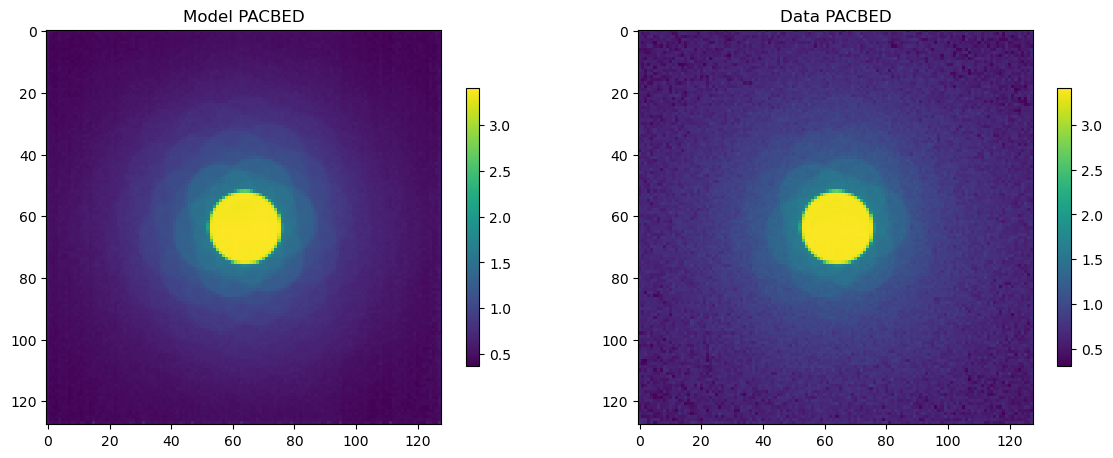

In [290]:
fig, axs = plt.subplots(1,2, figsize=(14,6))
im0=axs[0].imshow(model_CBEDs.mean(0).pow(0.2).detach().cpu())
axs[0].set_title("Model PACBED")
fig.colorbar(im0, shrink=0.6)
im1=axs[1].imshow(measurements[batch].mean(0).pow(0.2).detach().cpu())
axs[1].set_title("Data PACBED")
fig.colorbar(im1, shrink=0.6)
plt.show()

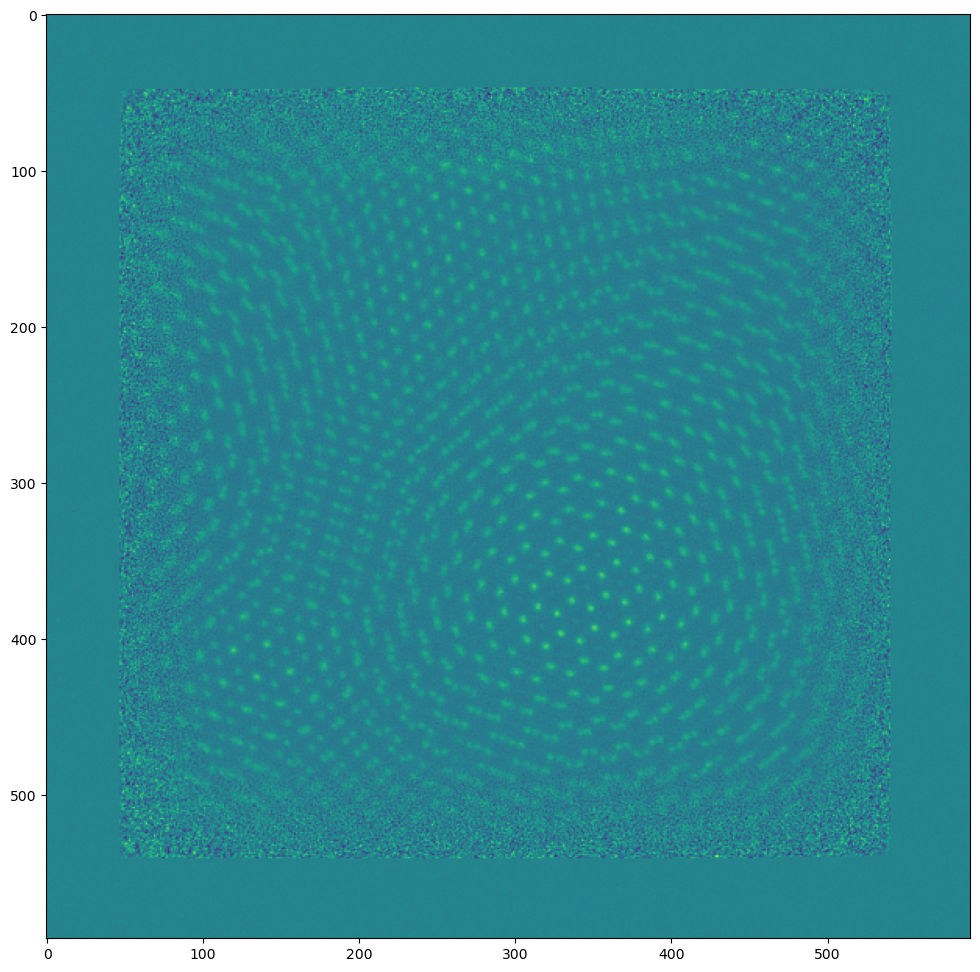

In [119]:
plt.figure(figsize=(12,12))
plt.imshow(model.opt_obj.detach().cpu()[0,:,:,:,1].sum(0))
plt.show()

In [120]:
from tifffile import imwrite
imwrite("output/AD_image_WSe2_random_z10_16Ang.tif", model.opt_obj.detach().cpu().numpy()[0,...,1].astype('float32'))

# Testing region

In [203]:
z_distance = 6/6 # Ang 10.803
_, H, _, _ = near_field_evolution(probe.shape[-2:], z_distance, lambd, extent, use_ASM_only=True, use_np_or_cp='np')

np.random.seed(42)
init_obj      = np.exp(1j * 0.05*np.random.rand(1,6,592,592)).astype('complex64') # init_obj = object_data
#init_obj      = np.exp(1j * 0.05*np.random.rand(*object_data.shape)).astype('complex64') # init_obj = object_data
#init_obj              = object_data
init_probe            = probe_data
init_crop_pos         = crop_indices_data
init_probe_pos_shifts = shift_vec_data
measurements  = torch.from_numpy(cbeds_data).cuda()

model = PtychoAD(init_obj, init_probe, init_crop_pos, init_probe_pos_shifts, H, 
                lr_params={'obj': 1e-3, 
                           'probe': 0, 
                           'probe_pos_shifts': 0},
                device=DEVICE)

opt = torch.optim.Adam(model.optimizer_params)

PtychoAD major variables:
obj: torch.Size([1, 6, 592, 592, 2]), torch.float32, device:cuda:0, grad:True, lr:1e-03
probe: torch.Size([10, 128, 128, 2]), torch.float32, device:cuda:0, grad:False, lr:0e+00
probe_pos_shifts: torch.Size([16384, 2]), torch.float32, device:cuda:0, grad:False, lr:0e+00


In [295]:


from time import time
from IPython.display import clear_output
from torchmetrics.image import TotalVariation
# https://lightning.ai/docs/torchmetrics/stable/image/total_variation.html 
# This TV only applies to the last 2 dim (N,C,H,W)

NITER = 10
BATCH_SIZE = 32 # The actual batch size would only be "close" if it's not divisible by len(measurments)
num_batch = len(measurements)/BATCH_SIZE
cbed_shape = measurements.shape[1:]
loss_iters = []

Softplus = torch.nn.Softplus(beta=100, threshold=2)
tv = TotalVariation().to(DEVICE)
for iter in range(NITER):
    loss_batches = []
    np.random.seed(42)
    shuffled_indices = np.random.choice(len(measurements), size = len(measurements), replace=False) # Creates a shuffled 1D array of indices
    batches = np.array_split(shuffled_indices, num_batch) # return a list of `num_batch` arrays, or [batch0, batch1, ...]
    start_iter_t = time()
    for batch_idx, batch in enumerate(batches):
        start_batch_t = time()
        
        opt.zero_grad()
        model_CBEDs = model(batch)
        measured_CBEDs = measurements[batch]
        
        loss_single     = cbed_rmse(model_CBEDs.sqrt(), measured_CBEDs.sqrt())    
        loss_pacbed     = 0 #0.5*cbed_rmse(model_CBEDs.mean(0).pow(0.2), measured_CBEDs.mean(0).pow(0.2)) # Ensuring the Position-averaged CBED are consistent as well
        loss_tv         = 0 #1e-7 * tv(model.opt_obj[:,1])
        loss_l1         = 0 #0.5*torch.mean(model.opt_obj[:,1].abs())
        loss_batch      = loss_single + loss_pacbed + loss_tv + loss_l1
        
        loss_batch.backward()
        opt.step()
        
        torch.cuda.synchronize() # This will pause the timing on CPU until CUDA is actually done
        end_batch_t = time()

        # #Update the plots after each update
        # AD_image = np.angle(model.opt_obj.detach().cpu()).sum(1)
        # Input_image = np.angle(object_data).sum(axis=1)[0]

        # # Show the figure per batch
        # clear_output(wait=True)   
        # fig = plot_recon_progress(iter, batch_idx, AD_image, Input_image)
        # plt.show()
        
        loss_batches.append(loss_batch)
        if batch_idx in np.linspace(0, len(batches)-1, num=11, dtype=int):
            print(f"Done batch {batch_idx} in iter {iter} in {(end_batch_t - start_batch_t):.2f} sec")

    torch.cuda.synchronize() # This will pause the timing on CPU until CUDA is actually done
    end_iter_t = time()
    loss_iters.append(sum(loss_batches)/len(loss_batches))
    print(f"Iter: {iter}, Loss_batch: {loss_batch:.4f}, Loss_single: {loss_single:.4f}, "
        f"Loss_pacbed: {loss_pacbed:.4f}, Loss_tv: {loss_tv:.4f}, Loss_L1: {loss_l1:.4f}, "
        f"in {(end_iter_t - start_iter_t)//60} min {(end_iter_t - start_iter_t)%60:02f} sec")
    # # Do a softplus constraint at the end of each iter without grad
    # with torch.no_grad():
    #     print(f"Applying softplus to obj phase for positivity after iter {iter}")
    #     model.opt_obj[:,1] = Softplus(model.opt_obj[:,1])
        
#imwrite("output/AD_image_WSe2_random_z12_16Ang.tif", model.opt_obj.detach().cpu().numpy()[0,...,1].astype('float32'))


Done batch 0 in iter 0 in 0.31 sec
Done batch 51 in iter 0 in 0.11 sec
Done batch 102 in iter 0 in 0.11 sec
Done batch 153 in iter 0 in 0.11 sec
Done batch 204 in iter 0 in 0.11 sec
Done batch 255 in iter 0 in 0.11 sec
Done batch 306 in iter 0 in 0.11 sec
Done batch 357 in iter 0 in 0.12 sec
Done batch 408 in iter 0 in 0.11 sec
Done batch 459 in iter 0 in 0.11 sec
Done batch 511 in iter 0 in 0.10 sec
Iter: 0, Loss_batch: 0.3789, Loss_single: 0.3789, Loss_pacbed: 0.0000, Loss_tv: 0.0000, Loss_L1: 0.0000, in 1.0 min 6.145142 sec
Done batch 0 in iter 1 in 0.11 sec
Done batch 51 in iter 1 in 0.11 sec
Done batch 102 in iter 1 in 0.11 sec
Done batch 153 in iter 1 in 0.12 sec
Done batch 204 in iter 1 in 0.11 sec
Done batch 255 in iter 1 in 0.12 sec
Done batch 306 in iter 1 in 0.11 sec
Done batch 357 in iter 1 in 0.11 sec
Done batch 408 in iter 1 in 0.12 sec
Done batch 459 in iter 1 in 0.11 sec
Done batch 511 in iter 1 in 0.11 sec
Iter: 1, Loss_batch: 0.3788, Loss_single: 0.3788, Loss_pacbed: 

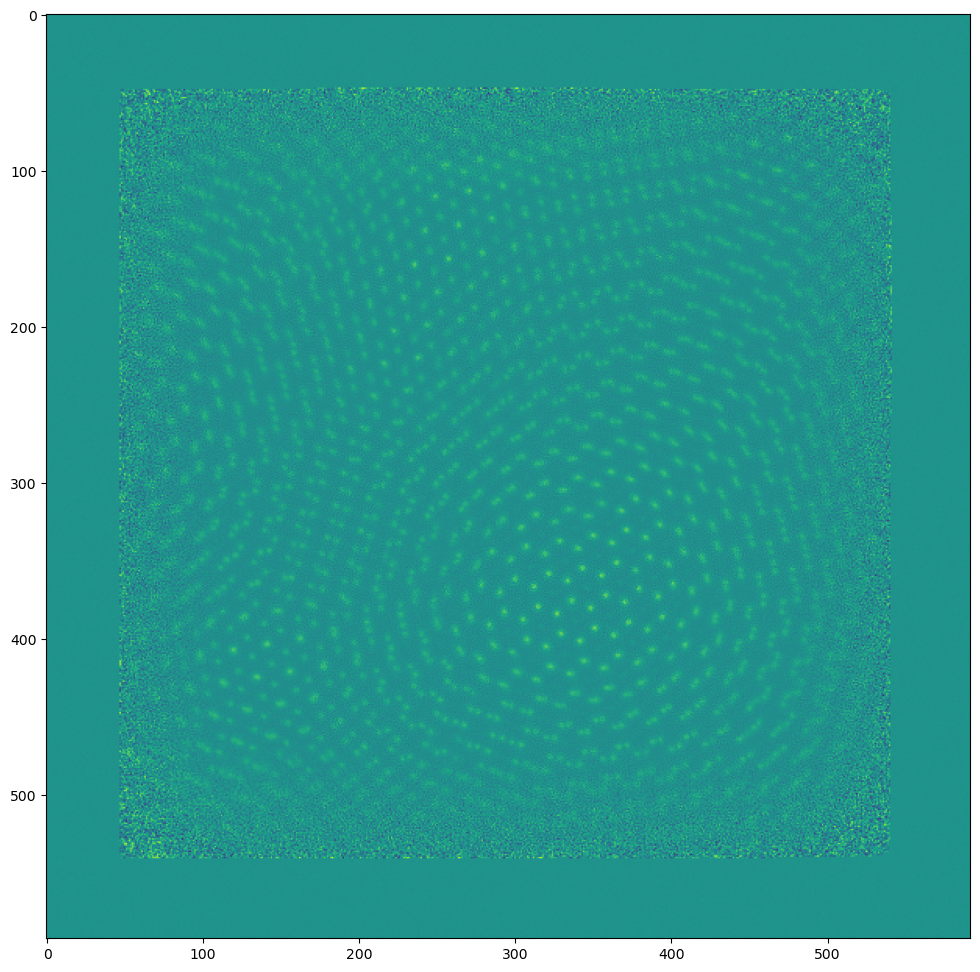

In [296]:
plt.figure(figsize=(12,12))
plt.imshow(model.opt_obj.detach().cpu()[0,:,:,:,1].sum(0))
plt.show()

In [297]:
model.opt_obj.grad[0,0,:,:,1].max()

tensor(0.0003, device='cuda:0')

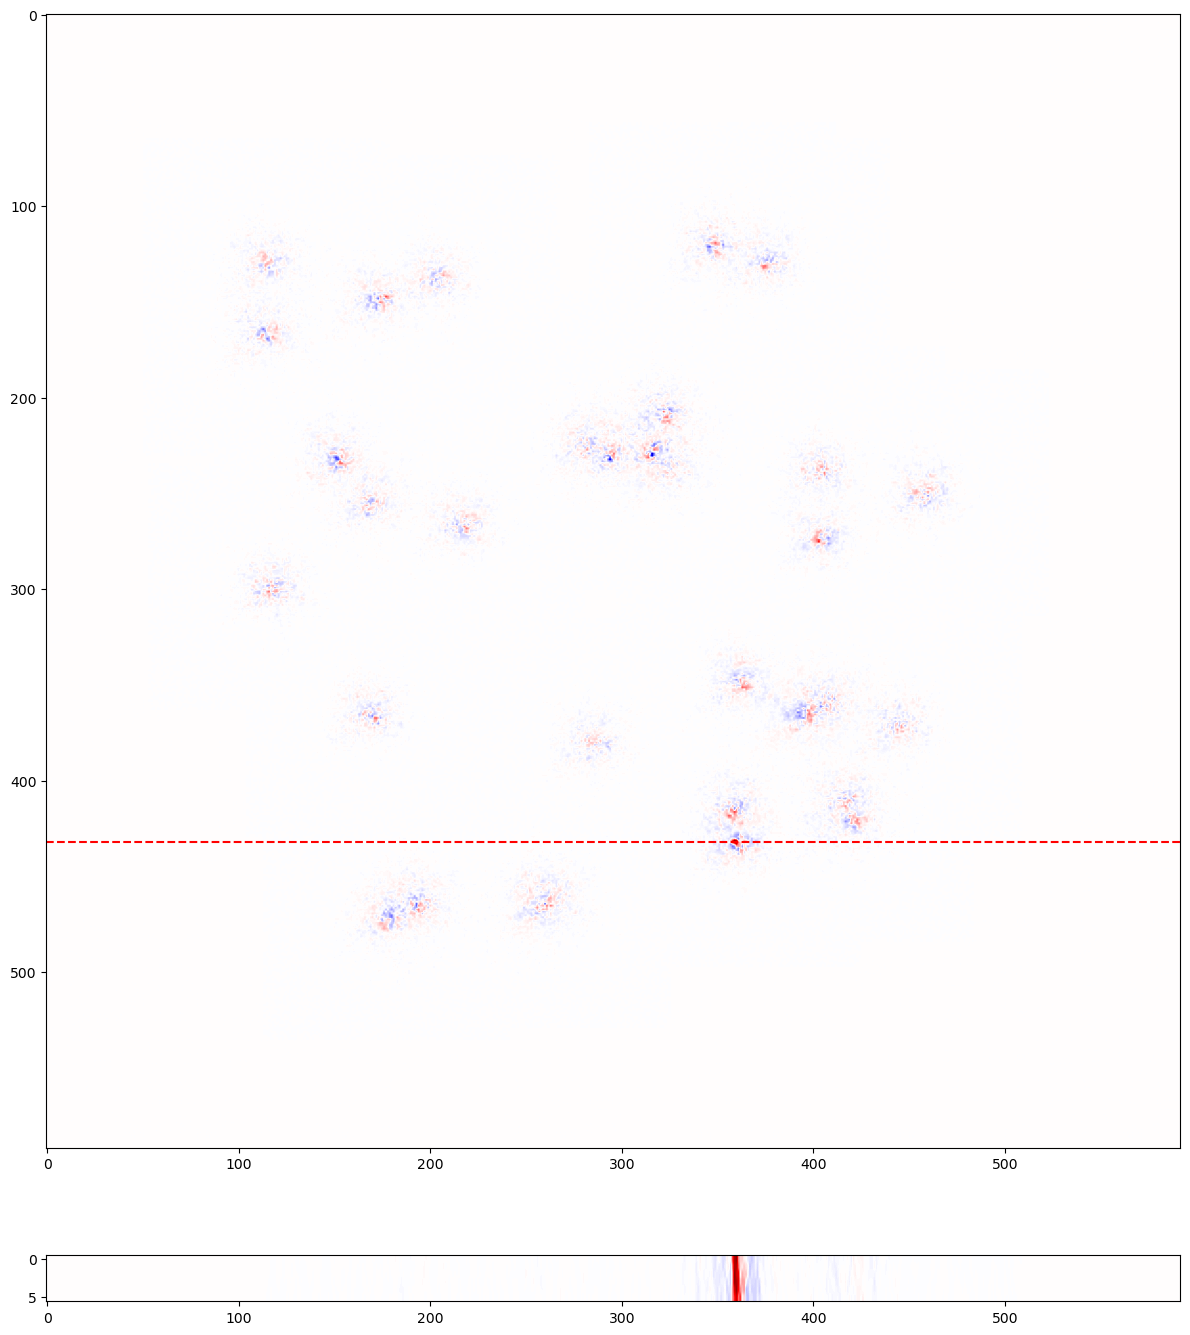

In [298]:
fig, axs = plt.subplots(2, 1, figsize=(12, 20))

# Plotting on the first subplot
im1 = axs[0].imshow(model.opt_obj.grad[0, 0, :, :, 1].detach().cpu(), cmap='seismic', vmin=-0.0003, vmax=0.0003)
axs[0].axhline(y=432, color='red', linestyle='--')  # Adjust the y value as needed


# Plotting on the second subplot
im2 = axs[1].imshow(model.opt_obj.grad[0, :, 432, :, 1].detach().cpu(), cmap='seismic', vmin=-0.0003, vmax=0.0003,  aspect=4)

# Adjusting the spacing between subplots
plt.subplots_adjust(wspace=0, hspace=-0.6)
plt.tight_layout()
plt.show()


In [299]:
from tifffile import imwrite
imwrite("output/AD_image_WSe2_random_z6_6Ang.tif", model.opt_obj.detach().cpu().numpy()[0,...,1].astype('float32'))

In [300]:
imwrite("output/AD_image_WSe2_random_z6_6Ang_grad_phase.tif", model.opt_obj.grad.detach().cpu().numpy()[0,...,1].astype('float32'))